In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
image_dir = '/content/drive/MyDrive/Colab Notebooks/leafs'

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import Sequential, layers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [13]:
import os

image_dir = '/content/drive/MyDrive/Colab Notebooks/leafs'

items = os.listdir(image_dir)
print(items)

['Healthy', 'Anthracnose', 'Bacterial Canker', 'Sooty Mould', 'Powdery Mildew', 'Die Back', 'Gall Midge', 'Cutting Weevil']


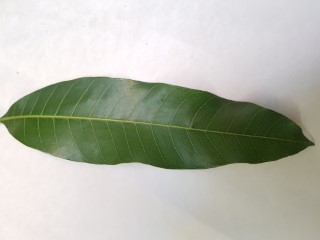

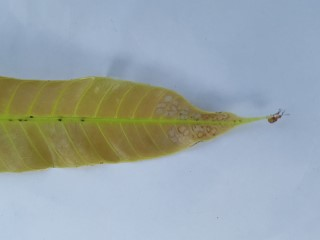

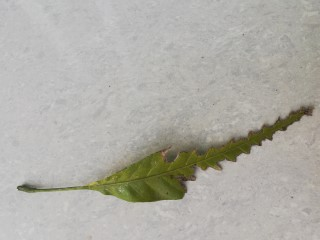

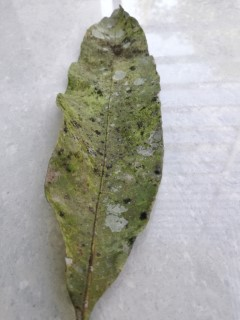

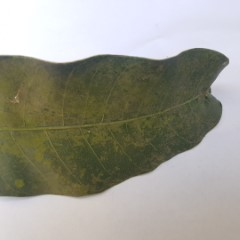

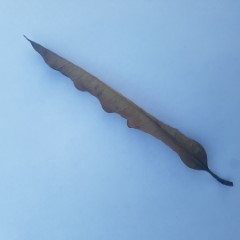

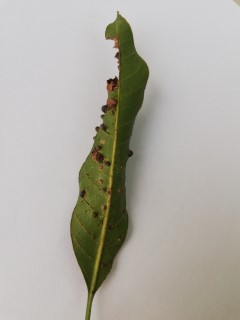

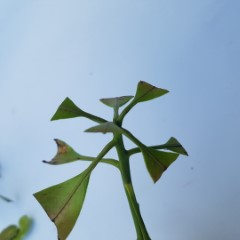

In [14]:
from IPython.display import display, Image, HTML

image_dir = '/content/drive/MyDrive/Colab Notebooks/leafs'

# List all folders in image_dir
folders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

# Display one sample image from each folder with folder name as title
for folder in folders:
    folder_path = os.path.join(image_dir, folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if images:  # Check if the folder contains any images
        sample_image = images[0]  # Get the first image as a sample
        image_path = os.path.join(folder_path, sample_image)
        display(HTML(f'<h3>{folder}</h3>'))
        display(Image(filename=image_path, width=200))

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/leafs',
    shuffle=True,
    image_size = (240, 320),
    batch_size = 32)

Found 4000 files belonging to 8 classes.


In [16]:
dataset.class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [17]:
len(dataset)

125

In [18]:
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # Get dataset size
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [19]:
# Example usage:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [20]:
for i in [train_ds, val_ds, test_ds]:
    print(len(i))

100
12
13


In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(240,320),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [23]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
])

In [24]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

In [25]:
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Apply resize_and_rescale and data augmentation
resize_and_rescale,
data_augmentation,

# Add convolutional layers with batch normalization and max pooling
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(240, 320, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Add fully connected layers with dropout and regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

# Output layer with softmax activation
model.add(Dense(8, activation='softmax'))

In [26]:
# Compile the model with a lower learning rate and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 240, 320, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 240, 320, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 120, 160, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 160, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 120, 160, 128)     512       
 chNormalization)                                                
                                                      

In [26]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20
100/100 [==============================] - 59s 350ms/step - loss: 2.4966 - accuracy: 0.6659 - val_loss: 3.9641 - val_accuracy: 0.4062
Epoch 2/20
100/100 [==============================] - 23s 227ms/step - loss: 1.2115 - accuracy: 0.8609 - val_loss: 1.5100 - val_accuracy: 0.7891
Epoch 3/20
100/100 [==============================] - 22s 224ms/step - loss: 0.9487 - accuracy: 0.9197 - val_loss: 0.8962 - val_accuracy: 0.9297
Epoch 4/20
100/100 [==============================] - 23s 229ms/step - loss: 0.9446 - accuracy: 0.9369 - val_loss: 0.8293 - val_accuracy: 0.9635
Epoch 5/20
100/100 [==============================] - 22s 221ms/step - loss: 0.8910 - accuracy: 0.9416 - val_loss: 0.8133 - val_accuracy: 0.9661
Epoch 6/20
100/100 [==============================] - 22s 221ms/step - loss: 0.8228 - accuracy: 0.9553 - val_loss: 0.8012 - val_accuracy: 0.9740
Epoch 7/20
100/100 [==============================] - 22s 224ms/step - loss: 0.8061 - accuracy: 0.9631 - val_loss: 0.9215 - val_ac

In [28]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 22s 59ms/step - loss: 15.8856 - accuracy: 0.1130


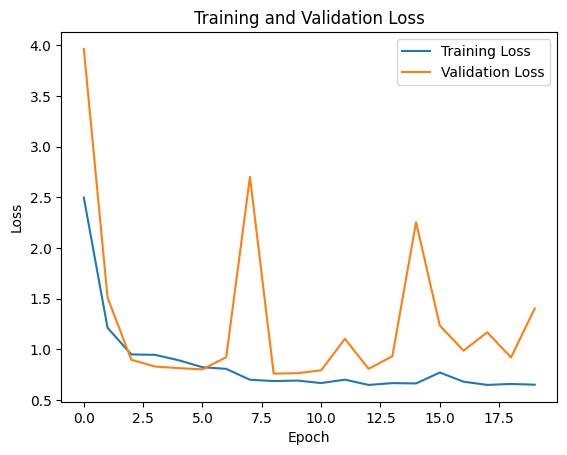

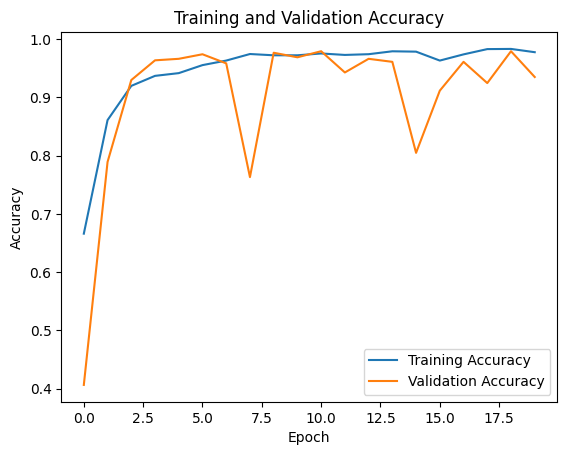

In [28]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model without classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 320, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers
model_vgg16 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Increase dropout rate
    Dense(64, activation='relu'),
    Dropout(0.3),  # Increase dropout rate
    Dense(8, activation='softmax')
])

# Compile the model
model_vgg16.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_vgg16 = model_vgg16.fit(train_ds,epochs=30,validation_data = val_ds)

Epoch 1/30
100/100 [==============================] - 61s 368ms/step - loss: 3.2847 - accuracy: 0.6225 - val_loss: 0.2644 - val_accuracy: 0.9245
Epoch 2/30
100/100 [==============================] - 22s 222ms/step - loss: 1.1810 - accuracy: 0.7925 - val_loss: 0.1455 - val_accuracy: 0.9557
Epoch 3/30
100/100 [==============================] - 22s 224ms/step - loss: 0.7918 - accuracy: 0.8544 - val_loss: 0.1425 - val_accuracy: 0.9635
Epoch 4/30
100/100 [==============================] - 22s 222ms/step - loss: 0.5294 - accuracy: 0.8997 - val_loss: 0.0529 - val_accuracy: 0.9818
Epoch 5/30
100/100 [==============================] - 23s 229ms/step - loss: 0.4991 - accuracy: 0.9144 - val_loss: 0.2100 - val_accuracy: 0.9766
Epoch 6/30
100/100 [==============================] - 22s 223ms/step - loss: 0.4101 - accuracy: 0.9231 - val_loss: 0.1634 - val_accuracy: 0.9688
Epoch 7/30
100/100 [==============================] - 22s 219ms/step - loss: 0.4357 - accuracy: 0.9247 - val_loss: 0.1407 - val_ac

In [30]:
scores = model_vgg16.evaluate(test_ds)

13/13 [==============================] - 3s 199ms/step - loss: 0.0414 - accuracy: 0.9952


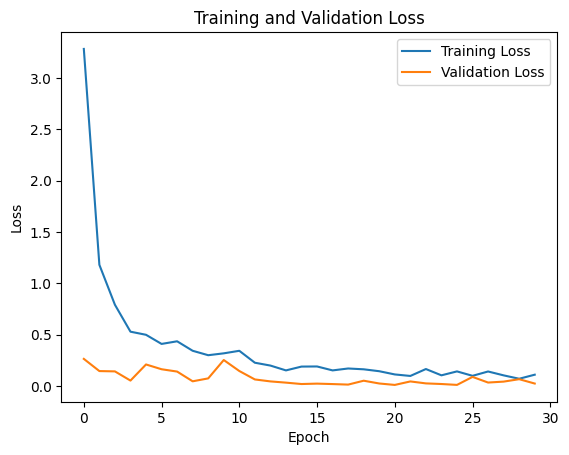

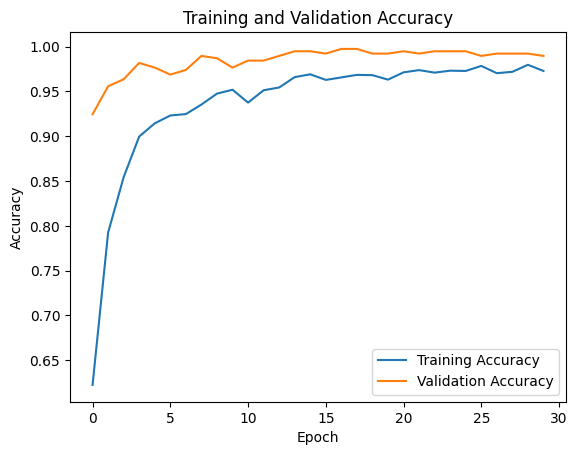

In [33]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [34]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 240, 320, 3)
[2 2 4 2 0 2 2 7 6 6 2 5 6 6 4 6 0 5 2 0 5 4 0 6 1 2 4 1 6 0 2 3]


first image to predict
actual label: Healthy
1/1 [==============================] - 0s 163ms/step
predicted label: Sooty Mould


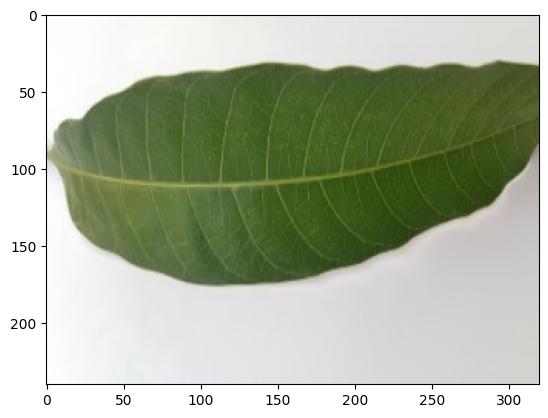

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",dataset.class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",dataset.class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = dataset.class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


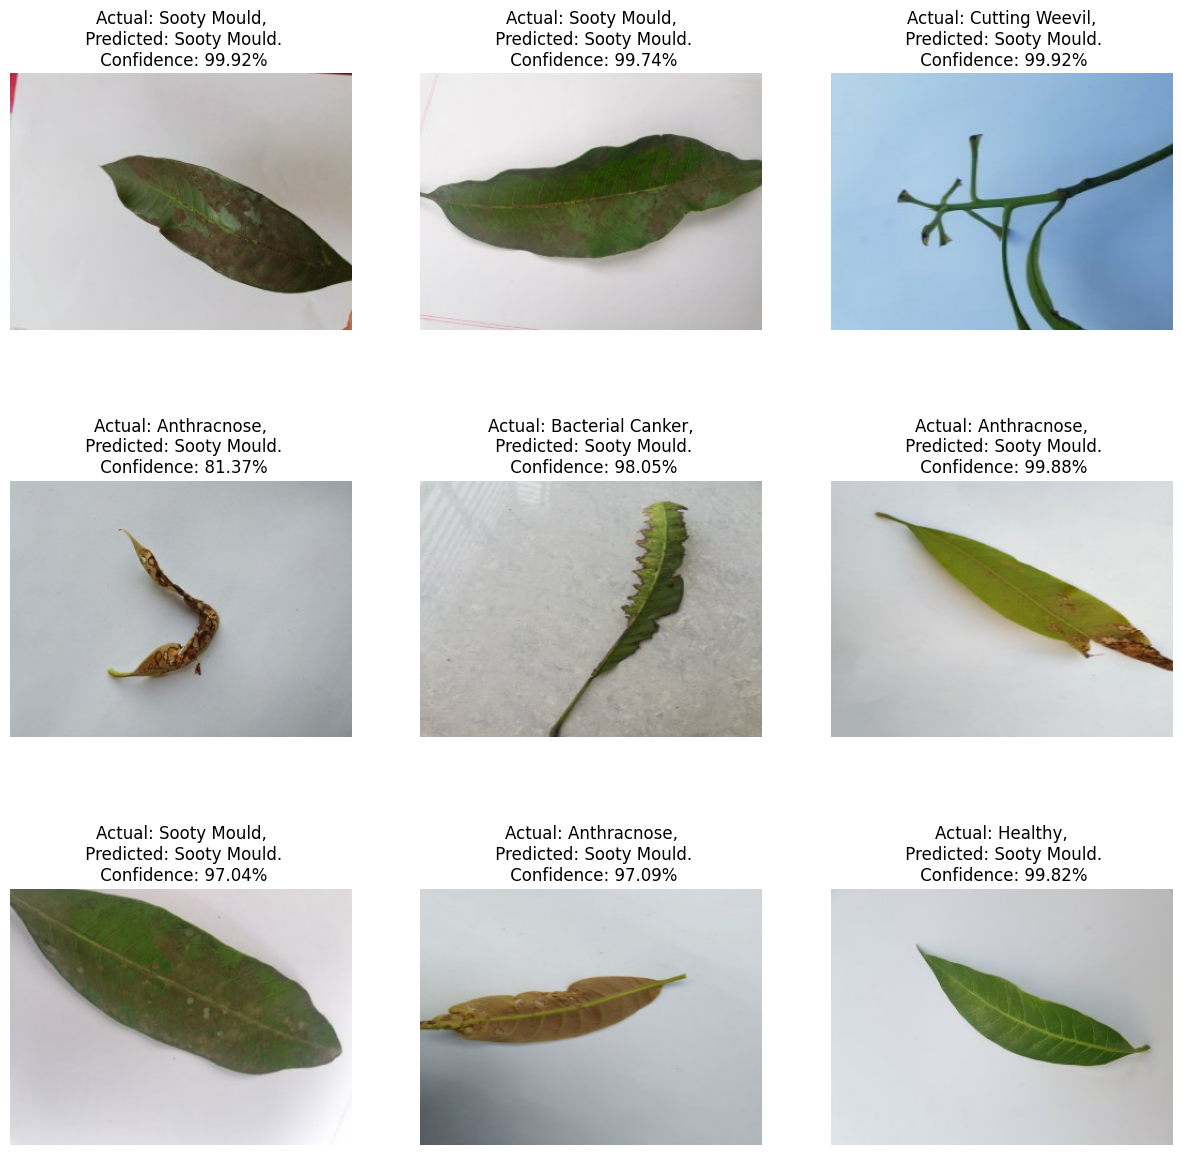

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = dataset.class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Write the TFLite model to a file
with open("model_leaf.tflite", 'wb') as f:
    f.write(tflite_model)